In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

z = 2
z2 = (1 + z) / 3

In [7]:
with open('rate.pkl', 'rb') as f:
    rata_arr = pkl.load(f)
    
rate_arr = np.array(rata_arr)
rate_arr = rate_arr.reshape(400,400) # [i][j]: gamma[i] theta[j], rate_arr[-1] = nan
rate_trans = np.transpose(rate_arr) # [i][j]: theta[i] gamma[j], rate_trans[i][-1] = nan

gamma_e_arr = np.logspace(8, 14, 400) * eV_to_erg / m_e / c**2 # lab-frame Lorentz factor of the electron produced
theta_e_arr = np.logspace(-8,0, 400)

In [180]:
t = 1e11

In [181]:
def get_nij(i, j): # nij = dN / (dV dgammae_j dOmegae_i)
    gamma6 = gamma_e_arr[j] / 1e6
    Gamma_IC = 1.1e-12 * z2**4 * gamma6
    
    gamma_max = 1 / (Gamma_IC * (1 / Gamma_IC / gamma_e_arr[j] - t))
    if gamma_max < 0:
        gamma_max = float('inf')
    
    
    nij = 0
    for jp in range(j, 399):
        if gamma_e_arr[jp] <= gamma_max:
            sum_ij = (gamma_e_arr[jp] - gamma_e_arr[jp-1]) * rate_trans[i][jp]
            nij += sum_ij
    nij = nij / (Gamma_IC * gamma_e_arr[j]**2)
    return nij

In [182]:
nij = np.zeros((400, 400)) # theta[i] gamma[j]
for i in range(400):
    for j in range(1, 400):
        nij[i][j-1] = get_nij(i, j)

In [183]:
def get_ni(i): # integrate gamma_e (1/gamma_e) nij
    ni = 0
    for j in range(1, 400):
        sum_i = (gamma_e_arr[j] - gamma_e_arr[j-1]) / gamma_e_arr[j] * nij[i][j]
        ni += sum_i
    return ni

In [184]:
ni = np.zeros((400, 1)) # about theta
for i in range(400):
    ni[i] = get_ni(i)

In [185]:
Omega_x = np.logspace(-8,0, 400).reshape(400, 1)

In [186]:
Px = np.zeros((400, 1))
for i in range(400): # Omega_x
    for j in range(1, 400): # theta
        if theta_e_arr[j-1] > Omega_x[i]:
            sum_ij = ni[j-1] * (np.sqrt(theta_e_arr[j]**2 - Omega_x[i]**2) - np.sqrt(theta_e_arr[j-1]**2 - Omega_x[i]**2))
            Px[i] += sum_ij

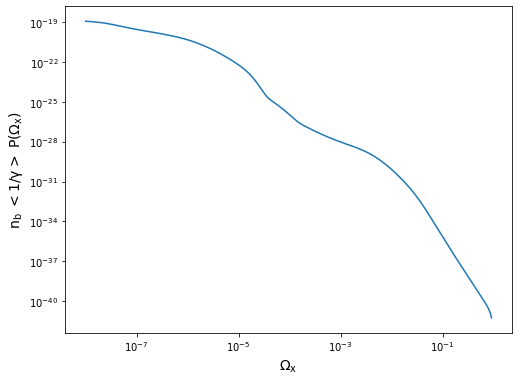

In [190]:
fig = plt.figure(figsize=(8, 6))
plt.plot(Omega_x[:-2], Px[:-2])
#plt.xlim([1e-8, 1e-7])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\mathrm{\Omega_x}$', fontsize = 14)
plt.ylabel('$\mathrm{n_b\ <1/\gamma>\ P(\Omega_x)}$', fontsize = 14)
plt.show()

In [188]:
Omega_x = Omega_x.reshape(400, 1)
slop = (Px[1:] - Px[:-1]) / (Omega_x[1:] - Omega_x[:-1])
print(Px.shape)
print(Omega_x.shape)
print(slop.shape)
print(np.where(abs(slop) == max(abs(slop))), max(abs(slop)))
print(Omega_x[6])
print(min(slop))

(400, 1)
(400, 1)
(399, 1)
(array([6]), array([0])) [2.5523992e-12]
[1.31916996e-08]
[-2.5523992e-12]
